In [1]:
import pandas as pd
import numpy as np
import reverse_geocoder as rg
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [2]:
data = pd.read_csv("data/ufo_sightings_scrubbed.csv",)

C:\Users\Kristina\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data = pd.read_csv("data/ufo_sightings_scrubbed.csv", dtype={"duration (seconds)": "string", "latitude": "string"})

There were warning while importing 'ufo_sightings_scrubbed.csv': `DtypeWarning: Columns (5,9) have mixed types.`. So I watched the columns "duration (seconds)" and "latitude". Found out that there are values 2\`, 8\`, 0.5\` in column "duration (seconds)" and value 33q.200088. 

The mark \` after numbers seems to be mark of minutes. Removed them. Changed column dtype to numeric(float64).

Value 33q.200088 should be 33.200088. I found the row with this value and Mescalero Indian Reservation location latitude is about the same as 33.200088. Changed column dtype to numeric(float64).

Also working with columns the "longitude" was actually "longitude ".

In [4]:
print('duration (seconds)')
for value in data['duration (seconds)']:
    try:
        float(value)
    except:
        print(value)
        
print('latitude')
for value in data['latitude']:
    try:
        float(value)
    except:
        print(value)


duration (seconds)
2`
8`
0.5`
latitude
33q.200088


In [5]:
data = data.replace('33q.200088', '33.200088')
data["latitude"] = pd.to_numeric(data["latitude"])

In [6]:
data = data.replace('2`', '2')
data = data.replace('8`', '8')
data = data.replace('0.5`', '0.5')
data["duration (seconds)"] = pd.to_numeric(data["duration (seconds)"])

In [7]:
data = data.rename(columns={'longitude ': 'longitude'})

Now need to decide, what to do with `null` values.

Since there is no null values in "latitude" and "longitude" columns it is possible to find values for columns "state" and "country". Found that there is ["Reverse Geocoder" Python library](https://github.com/thampiman/reverse-geocoder) where I give coordinates and get data about the place.

I checked with Reverse Geocoder, if there are any values from "country" that does not correspond to given coordinates with code:
```
from collections import Counter

coordinates = []

for i in data[data['country'].notnull()].index:
    coordinates.append((data.at[i, 'latitude'], data.at[i, 'longitude']))

results = rg.search(coordinates)  

result_i = 0
count = 0
wrong = []
for i in data[data['country'].notnull()].index:
    if (results[result_i].get('cc').lower() != data.at[i, 'country'].lower()):
        print('Koordinaatide järgi:', (results[result_i].get('cc').lower()))
        print('Andmetes märgitud:',data.at[i, 'country'])
        print(data.iloc[i])
        print(i)
        wrong.extend([data.at[i, 'country'] + '_' + results[result_i].get('cc').lower()]) 
        count += 1
    result_i += 1
    
Counter(wrong)
```

The code looked about 70,000 rows and found only 93 not correspondending places. I chekced some not correspondending places manually and came out that actually the country in data is correct, but the places are so near to country borders that sometimes Reverse Geocoder thought it should be neighbour country. For example Curlew, Washington is in US, but when I gave coordinates to Reverse Geocoder, it thought it has to be Canada. Maybe because Curlew is so small place thath Reverse Geocoder does not it in its database. Result of not correspondending places, where on first place is abbreviation of country in our data and second is from Reverse Geocoder {'us_pr': 25, 'us_ca': 15, 'ca_us': 45, 'us_ru': 3, 'us_mx': 5}.  us - USA, pr - Puerto Rico, ca - Canada, ru - Russia, mx - Mexico.
It means that I can trust the marked countries in our data and I can use Reverse Geocoder for NaN values. There could be some mistakes, but the amount of them can not be big. Also I trust now values of "state" columns.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  float64
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  float64
 10  longitude             80332 non-null  float64
dtypes: float64(3), object(8)
memory usage: 6.7+ MB


In [9]:
states = {
    'Alaska': 'ak',
    'Alabama': 'al',
    'Arkansas': 'ar',
    'Arizona': 'az',
    'California': 'ca',
    'Colorado': 'co',
    'Connecticut': 'ct',
    'District of Columbia': 'dc',
    'Delaware': 'de',
    'Florida': 'fl',
    'Georgia': 'ga',
    'Hawaii': 'hi',
    'Iowa': 'ia',
    'Idaho': 'id',
    'Illinois': 'il',
    'Indiana': 'in',
    'Kansas': 'ks',
    'Kentucky': 'ky',
    'Louisiana': 'la',
    'Massachusetts': 'ma',
    'Maryland': 'md',
    'Maine': 'me',
    'Michigan': 'mi',
    'Minnesota': 'mn',
    'Missouri': 'mo',
    'Mississippi': 'ms',
    'Montana': 'mt',
    'North Carolina': 'nc',
    'North Dakota': 'nd',
    'Nebraska': 'ne',
    'New Hampshire': 'nh',
    'New Jersey': 'nj',
    'New Mexico': 'nm',
    'Nevada': 'nv',
    'New York': 'ny',
    'Ohio': 'oh',
    'Oklahoma': 'ok',
    'Oregon': 'or',
    'Pennsylvania': 'pa',
    'Rhode Island': 'ri',
    'South Carolina': 'sc',
    'South Dakota': 'sd',
    'Tennessee': 'tn',
    'Texas': 'tx',
    'Utah': 'ut',
    'Virginia': 'va',
    'Vermont': 'vt',
    'Washington': 'wa',
    'Wisconsin': 'wi',
    'West Virginia': 'wv',
    'Wyoming': 'wy'
}

In [10]:
#Get all rows where country or state is null. Source: https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row
#Fill state onyl when it is US?
coordinates = []
result_i = 0
for i in data[data['country'].isnull() |  ((data['state'].isna()) & (data['country'] == 'us'))].index:
    
    coordinates.append((data.at[i, 'latitude'], data.at[i, 'longitude']))
    
results = rg.search(coordinates)

for i in data[data['country'].isnull() |  ((data['state'].isna()) & (data['country'] == 'us'))].index:
    if pd.isna(data.at[i, 'country']):
        data.at[i, 'country'] = results[result_i].get('cc').lower()
        
    if (pd.isna(data.at[i, 'state'])) & (data.at[i, 'country'] == 'us'):
        data.at[i, 'state'] = states.get(results[result_i].get('admin1'))
        
    result_i += 1

Loading formatted geocoded file...


Now need to do something with shape values. Since the value "light" is most represented, 16,565 times and second most represented value is "triangle", 7865 times, then it seems to okay use "light" value for ~2000 NaN values. Also some shapes should be renamed like "round" to "circle" , because the meaning of them is same.

In [11]:
data['shape'] = data['shape'].replace(np.nan, 'light')
data['shape'] = data['shape'].replace('round', 'circle')
data['shape'] = data['shape'].replace('changed', 'changing')

Median value of duration in seconds. Since some numbers are too high (there was 31 years), it is smarter to find median value.

In [12]:
data['duration (seconds)'].median()

180.0

Changing duration values into range, so it would be possible to make graph of them.

In [13]:
bins= [0,30,60,120,300,600,1800,3600,97837000]
labels = ['0-0.5','0.5-1','1-2','2-5','5-10','10-30','30-60','60+']
data['duration (minutes) ranges'] = pd.cut(data['duration (seconds)'], bins=bins, labels=labels, right=False)

In [14]:
data.value_counts('duration (minutes) ranges')

duration (minutes) ranges
0-0.5    18118
10-30    14650
2-5      14430
5-10     10882
1-2       6780
0.5-1     5469
60+       5407
30-60     4596
dtype: int64

Saving to new .csv file.

In [15]:
data.to_csv('data/ufo_sightings_cleaned.csv', encoding='utf-8', index=False)

In [14]:
data_new = pd.read_csv("data/ufo_sightings_cleaned_new.csv")

In [15]:
coords = data_new[['latitude','longitude']]

Here I took the latitude and longitude sightings to find out where potentially a UFO hotspot could be. I got the coordinates 47.606 -122.331 which is positioned in Seattle.

In [16]:
data_new['latitude'] = data_new.latitude.round(4)

In [17]:
data_new['longitude'] = data_new.longitude.round(4)

In [18]:
data_new['latitude'].value_counts()

47.6064    581
40.7142    529
33.4483    475
34.0522    394
36.1750    388
          ... 
44.7089      1
49.1344      1
33.4418      1
26.2350      1
50.4658      1
Name: latitude, Length: 17833, dtype: int64

In [19]:
data_new['longitude'].value_counts()

-122.3308    581
-74.0064     529
-112.0733    475
-118.2428    392
-115.1364    388
            ... 
-112.3973      1
-97.5817       1
-89.1350       1
-45.0014       1
 22.8918       1
Name: longitude, Length: 19192, dtype: int64

In this segment, work begins with the geopandas module. Basically all these maps are a type of dataframe called GeoDataFrame. The borders are shapely Polygon objects which define where a country or region is positioned relative to the world.

<AxesSubplot:>

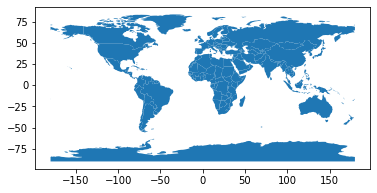

In [20]:
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))
world.plot()

In [21]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In geopandas you can also do layered maps, so you can position different markers on maps. The following code was done using a tutorial made by Regis Nisengwe the link for which can be found [here](https://www.linkedin.com/pulse/geopandas-plotting-data-points-map-using-python-r%C3%A9gis-nisengwe/).  
First of all we need to define a coordinate reference system (CRS) to tell Python how these coordinates are positioned in reference to the Earth. Then we need to define the geometry which tells Python where to place these new Point objects we've just created. 

C:\Users\Kasutaja\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

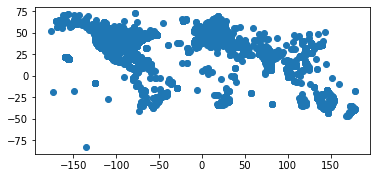

In [22]:
crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(coords['longitude'],coords['latitude'])]
geodata=gp.GeoDataFrame(coords,crs=crs,geometry=geometry)
geodata.plot()

Finally, let's plot one geodata plot over another.

Text(39.875, 0.5, 'Latitude')

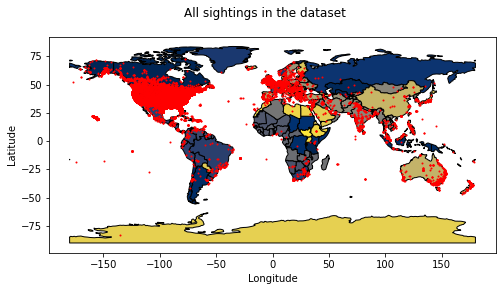

In [23]:
fig, ax = plt.subplots(figsize=(8,4))
world.plot(ax=ax, facecolor='Grey',edgecolor='k',alpha=1,linewidth=1,cmap="cividis")
geodata.plot(ax=ax, color='red',markersize=1)
fig.suptitle('All sightings in the dataset',fontsize=12)
ax.set_xlabel('Longitude',fontsize=10)
ax.set_ylabel('Latitude',fontsize='medium')

Down below is just an experiment with only US data, which sadly never got used.

In [24]:
#datascience.quantecon.org/applications/maps.html
state_df = gp.read_file("data/cb_2016_us_state_5m.zip")
state_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131173688951,4593686489,"MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1477946266785,245390495931,"MULTIPOLYGON (((-133.65582 55.62562, -133.6249..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198560125,1027346486,"POLYGON ((-114.79968 32.59362, -114.80939 32.6..."
3,08,01779779,0400000US08,08,CO,Colorado,00,268429343790,1175112870,"POLYGON ((-109.06025 38.59933, -109.05954 38.7..."
4,09,01779780,0400000US09,09,CT,Connecticut,00,12542638347,1815476291,"POLYGON ((-73.72777 41.10070, -73.69595 41.115..."


<AxesSubplot:>

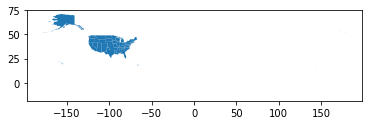

In [25]:
state_df.plot()